# Maximal Quantum Violations for the $I_{3322}$ Bell Inequality


Consider the bipartite non-signaling scenario where Alice and Bob each have three classical inputs and two classical outputs.
The Bell inequalities bounding this scenario are computed in full by [I. Pitowsky and K. Svozil](https://journals.aps.org/pra/).
It was later shown by [D. Collins and N. Gisin](https://iopscience.iop.org/article/10.1088/0305-4470/37/5/021/meta?casa_token=RZb3nMLhJIUAAAAA:gF2JkOypzzEwTxiTiC19UN3lBPUiq2MW0KB47JcD7LNh4GyoF2-dTE1YyB7qu9SWkg5sO1AoyfM) that there is one novel Bell inequality for this scenario, the $I_{3322}$ inequality.
For inputs $x,y\in \{0,1,2\}$ and outputs $a,b\in \{0,1\}$, the $I_{3322}$ Bell inequality is expressed as

\begin{align}
    I_{3322} := &-P_A(0|0) -2P_B(0|0) - P_B(0|1) + P(00|00) +P(00|01) + P(00|02) \\
    &+ P(00|10) + P(00|11) - p(00|12) + P(00|20) - P(00|21) 
\end{align}

The classical upper bound is $I_{3322} \leq \beta_C = 0$.
An interesting feature of this inequality is that the amount of quantum violation increases with larger entanglement Hilbert space dimensions.
Bounds for the infinite dimensional quantum case were produced by [K. Pal and T. Vertesi](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.82.022116) and found to be $I_{3322}\leq \beta_Q \leq 0.250\: 875\: 38$.

In [116]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from context import QNetOptimizer as QNopt

## Qubit Case

The maximal violation is found to be 0.25 for local measurements on single qubits.

In [105]:
num_qubits = 2

prepare_nodes = [QNopt.PrepareNode(1,range(num_qubits),qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits)-1)]
measure_nodes = [
    QNopt.MeasureNode(3,2, [0], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1),
    QNopt.MeasureNode(3,2, [1], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1)
]

qubit_ansatz = QNopt.NetworkAnsatz(prepare_nodes, measure_nodes)

In [127]:
def _I_3322_qnode(network_ansatz):
    # just measure one qubit in each measurement node...
    wires = qml.wires.Wires([node.wires[0] for node in network_ansatz.measure_nodes])
    
    @qml.qnode(network_ansatz.dev)
    def circuit(prepare_settings, measure_settings):
        network_ansatz.fn(prepare_settings, measure_settings)
        
#         return qml.probs(wires=network_ansatz.dev.wires)
        return qml.probs(wires=wires)

    
    return circuit

def _I_3322_cost(network_ansatz):
    
    I_3322_qnode = _I_3322_qnode(network_ansatz)
    
    def cost(scenario_settings):
        θ = network_ansatz.layer_settings(scenario_settings[0], [0])
        score = 0

        # P(00|xy) contributions
        a, b = 0, 0
        for (x, y, mult) in [(0,0,1),(0,1,1),(0,2,1),(1,0,1),(1,1,1),(1,2,-1),(2,0,1),(2,1,-1)]:
            ϕ = network_ansatz.layer_settings(scenario_settings[1], [x, y])

            probs_xy = np.reshape(I_3322_qnode(θ, ϕ), (2,2))       
            score += mult * probs_xy[a,b]

        ϕ_00 = network_ansatz.layer_settings(scenario_settings[1], [0,0])
        
        # TODO: Post-process probability vector from `I_3322_qnode(θ, ϕ_00)` to handle multi-qubit case
        probs_00 = np.reshape(I_3322_qnode(θ, ϕ_00), (2,2))

        # - P_A(0|0)
        score += -1 * sum([probs_00[0,b] for b in [0,1]])

        # - 2 * P_B(0|0)
        score += -2 * sum([probs_00[a,0] for a in [0,1]])

        ϕ_11 = network_ansatz.layer_settings(scenario_settings[1],[1,1])
        probs_11 = np.reshape(I_3322_qnode(θ, ϕ_11), (2,2))

        # - P_B(0|1)
        score += -1 * sum([probs_11[a,0] for a in [0,1]])

        return -(score)    

    return cost

In [128]:
# perform gradient descent
init_settings = qubit_ansatz.rand_scenario_settings()
I_3322_cost = _I_3322_cost(qubit_ansatz) 

opt_dict = QNopt.gradient_descent(I_3322_cost, init_settings, step_size = 0.1, num_steps=300)

iteration :  0 , score :  -0.8409594057423448
settings :
 [[tensor([[-2.60628506, -1.82206961, -2.65037457, -1.35453594, -0.55644692,
          2.78286478, -1.52349372, -0.28663798,  0.08807983,  1.98305282,
         -3.08067583,  1.94006203, -2.98997325,  2.84534235, -1.61909747]], requires_grad=True)], [tensor([[ 2.89373196, -1.35179362, -0.84678642],
        [-1.24782949,  0.01819529,  0.13817541],
        [-1.30162467, -2.28752913,  0.9870405 ]], requires_grad=True), tensor([[ 2.6550312 , -1.31513425,  1.85788295],
        [ 0.64132201, -1.51422063,  2.9834108 ],
        [-2.31723108,  2.44836515,  2.20884448]], requires_grad=True)]] 

iteration :  25 , score :  0.046740265955700924
settings :
 [[array([[-2.9987693 , -1.72660555, -3.0468914 , -1.00345382, -0.59393765,
         2.69893469, -1.40989637, -0.28207349,  0.03576276,  2.12827166,
        -2.9485209 ,  1.52408507, -2.98724458,  2.71657466, -1.47085867]])], [array([[ 2.88014755, -1.62467822, -0.84678642],
       [-0.8936512

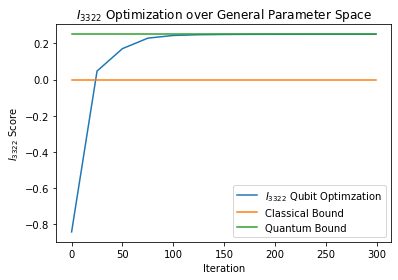

In [129]:
# Plot the score of the Bell throughout the optimization inequality
plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$ Qubit Optimzation")
plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound")
plt.title(r"$I_{3322}$ Optimization over General Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

## Two-Qubit Case

In [130]:
num_qubits = 4

prepare_nodes = [QNopt.PrepareNode(1,range(num_qubits),qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits)-1)]
measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1),
    QNopt.MeasureNode(3,2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 4**(num_qubits//2) - 1)
]

qubit_ansatz2 = QNopt.NetworkAnsatz(prepare_nodes, measure_nodes)

In [ ]:

init_settings = qubit_ansatz2.rand_scenario_settings()
I_3322_cost2 = _I_3322_cost(qubit_ansatz2) 

QNopt.gradient_descent(I_3322_cost2, init_settings, step_size = 0.1, num_steps=300)

iteration :  0 , score :  -1.4532131554171692
settings :
 [[tensor([[-1.79326519, -2.02026078,  1.71506001,  1.47996936, -0.0476354 ,
         -1.78841817, -0.98301086,  2.94911848,  2.63895143,  0.28367672,
          1.57854234,  2.00495469, -2.99007327, -3.11208773,  0.81276684,
         -0.31935308, -1.18790306,  2.49950127, -0.409548  , -1.47156298,
          0.71072748, -0.80535593, -2.96904439,  2.20971801, -2.73651447,
          2.28307473,  2.60517322,  2.46962522,  0.05270578, -2.98271576,
          2.74712777,  2.40222026,  2.29747276, -1.857807  ,  0.32222743,
          0.55858856,  2.48691789,  0.39239711,  0.85524782, -2.22770544,
          0.97093096, -0.0895097 , -1.18150425,  1.72025864, -3.05149493,
         -1.19486905,  1.67817255,  2.96141639, -3.08438073, -2.97801327,
         -0.17694181, -0.38226831, -1.05370686,  2.36553056, -1.81509876,
          1.8030257 , -3.0841391 ,  2.85068482,  0.928262  , -0.273112  ,
          2.25844139, -0.83249969,  0.51302125,  1.1

iteration :  50 , score :  0.20564411221311824
settings :
 [[array([[-1.84113706, -2.01781483,  1.66801685,  1.4623599 , -0.04692029,
        -1.79965328, -1.03061246,  2.97898657,  2.63211367,  0.28525405,
         1.69257571,  1.97347312, -2.97967508, -3.161584  ,  0.83424375,
        -0.22829101, -1.22037784,  2.52862506, -0.44353436, -1.48887847,
         0.73229144, -0.77605082, -3.01547828,  2.14455138, -2.77651922,
         2.32588271,  2.6199325 ,  2.51242992,  0.10605161, -2.92814359,
         2.70163066,  2.37763157,  2.24038304, -1.86985165,  0.38066662,
         0.57311376,  2.50166524,  0.30409743,  0.83761132, -2.2049171 ,
         1.0071428 , -0.0654826 , -1.15888715,  1.76371577, -3.08190028,
        -1.23301387,  1.56047363,  3.01107911, -3.0700462 , -3.03442487,
        -0.22326412, -0.39750352, -1.16676366,  2.41694089, -1.9218802 ,
         1.8221936 , -3.11801447,  2.77389263,  0.89445594, -0.24503583,
         2.28692052, -0.71664764,  0.44049888,  1.21868971, -0.

iteration :  100 , score :  0.2402029991435144
settings :
 [[array([[-1.85342424, -2.01819896,  1.65752647,  1.4642655 , -0.04382907,
        -1.80633467, -1.0409783 ,  2.96915346,  2.63256422,  0.28953102,
         1.69607828,  1.97711883, -2.9856369 , -3.1590909 ,  0.84154737,
        -0.2298427 , -1.2281122 ,  2.54301447, -0.43592522, -1.4856099 ,
         0.71466122, -0.78633818, -3.01084607,  2.13509835, -2.77114458,
         2.32740919,  2.62076913,  2.50591815,  0.10041766, -2.92521986,
         2.6887338 ,  2.37697687,  2.2332404 , -1.87759954,  0.39440087,
         0.56682233,  2.49737667,  0.29827986,  0.83746555, -2.21240764,
         1.00603129, -0.05840784, -1.15361664,  1.77421118, -3.08846618,
        -1.23051174,  1.55350691,  3.01537694, -3.06022083, -3.04395425,
        -0.22297189, -0.39550057, -1.17338915,  2.43203957, -1.93105531,
         1.81984382, -3.12718392,  2.76934553,  0.87882105, -0.24690022,
         2.29722976, -0.70653819,  0.44016331,  1.21801687, -0.

In [42]:
scenario_settings = ansatz.rand_scenario_settings()

In [45]:
I_3322_cost(scenario_settings)

tensor(1.28145876, requires_grad=True)

In [44]:
scenario_settings[0][0][0]


tensor([-0.54631776, -0.81855714,  1.16031831, -1.44966089, -0.28628307,
        -2.49008104,  0.26075946,  2.1370557 , -2.85585357, -0.94767687,
        -0.74345663,  2.22034367, -0.54111641,  0.65043168,  1.45645556], requires_grad=True)

In [12]:
ansatz.layer_settings(scenario_settings[1], [0,0])

[tensor([0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0.], requires_grad=True)]

In [13]:
 for (x, y, mult) in [(0,0, 1),(1,0,-1)]:
        
        print(x, y, mult)
    

0 0 1
1 0 -1


In [30]:
sum([x + 2 for x in range(2)])

5

In [58]:
ansatz.dev.wires

<Wires = [0, 1]>

In [70]:
def RY_circ(settings, wires):
    qml.RY(settings[0],wires = wires)

In [75]:
p_nodes = [
    QNopt.PrepareNode(1,[0],RY_circ,1),
    QNopt.PrepareNode(1,[1],RY_circ,1),
]

m_nodes = [
    QNopt.MeasureNode(2,2,[0], RY_circ,1),
    QNopt.MeasureNode(2,2,[1], RY_circ,1),
]

n_ansatz = QNopt.NetworkAnsatz(p_nodes,m_nodes)

@qml.qnode(n_ansatz.dev)
def n_qnode(prep_settings, meas_settings):
    n_ansatz.fn(prep_settings, meas_settings)
    
    return qml.probs(wires=n_ansatz.dev.wires)


In [87]:
settings = n_ansatz.zero_scenario_settings()
settings[0][0][0] = np.pi
θ = n_ansatz.layer_settings(settings[0],[0,0])

ϕ = n_ansatz.layer_settings(settings[1],[0,0])

probs = n_qnode(θ,ϕ)



In [89]:
np.reshape(probs, (2,2))

tensor([[3.74939946e-33, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00]], requires_grad=True)

In [114]:
opt_dict

{'opt_score': tensor(0.24999055, requires_grad=True),
 'opt_settings': [[array([[-3.14324629, -1.34771451, -1.45206593,  2.35087561, -2.16306964,
           -0.81020995,  0.40171215, -2.27039991, -0.71564583, -3.18848397,
            2.68763468,  1.38986846,  0.30709773, -0.7838134 ,  2.10628412]])],
  [array([[-1.35326738,  1.44120099,  2.58657573],
          [-1.69825883,  0.40472808, -0.22190964],
          [-0.42152118, -0.25471903,  1.21877283]]),
   array([[ 0.38142352,  2.53459345,  0.77373312],
          [ 0.81468242, -2.78658966,  2.37083171],
          [-0.94930694,  0.04657781, -0.22004505]])]],
 'scores': [tensor(-1.05711404, requires_grad=True),
  tensor(-0.05505341, requires_grad=True),
  tensor(0.02964356, requires_grad=True),
  tensor(0.11444717, requires_grad=True),
  tensor(0.1956957, requires_grad=True),
  tensor(0.23291225, requires_grad=True),
  tensor(0.24452773, requires_grad=True),
  tensor(0.24815892, requires_grad=True),
  tensor(0.2493672, requires_grad=True)

In [121]:
ansatz.dev.wires[0]

0